In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np

/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [2]:
# Parameters
# mesh_path  ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path  = None #'~/figures/test_papermill/'
save_fname = None

#_____________________________________________________________________________________
which_cycl = None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode = 'hslice_clim'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname      = 'salt'
year       = [1979,2019]
mon, day, record, box, depth = None, None, None, None, 1000

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [1979,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
which_clim = 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr       = 'blue2red'
cnum       = 20
cref       = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn    = 2 
do_rescale = None
which_dpi  = 300
proj       = 'pc'
do_plot    = 'tcf'

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, ipath, input_paths[ii])

    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
# else:
#     do_reffig=False
    
# #______________________________________________________________________________________________________
# # in case of diff plots
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record    
        
# #______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path is not None) and (ref_path is not "None"): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths, ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [8]:
#___LOAD Climatology DATA______________________________________________________________________________
clim_vname = vname
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth != 'bottom'): 
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
else: raise ValueError('climatology not supported for choosen vname')    

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                depth=depth, descript=descript, do_info=False)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    data_list.append(tpv.do_anomaly(data, clim))
    del data   

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/


[-180, 180, -90, 90]
--> histo: cmin, cmax =  -0.6605544018922038 0.33358505877742006
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -0.66, 'cmax': 0.33, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fd9285c6290>, 'clevel': array([-0.675, -0.65 , -0.625, -0.6  , -0.575, -0.55 , -0.525, -0.5  ,
       -0.475, -0.45 , -0.425, -0.4  , -0.375, -0.35 , -0.325, -0.3  ,
       -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125, -0.1  ,
       -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,  0.1  ,
        0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,
        0.325,  0.35 ])}


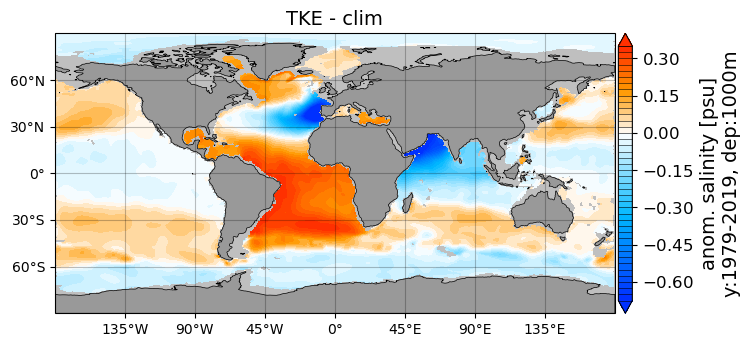

In [9]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = data_list[0][sname].attrs['str_lsave']
if spath is not None: spath = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(data_list)])    
nrow   = np.ceil(len(data_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
fig, ax, cbar = tpv.plot_hslice(mesh, data_list, cinfo=cinfo, box=box, n_rc=[nrow, ncolumn], 
                            figsize=[ncolumn*7, nrow*3.5], proj = proj,  do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', 
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)